In [ ]:
!wget -nc https://www.solarsystemscope.com/textures/download/8k_earth_daymap.jpg
!wget -nc https://www.spacespheremaps.com/wp-content/uploads/rich_blue_nebulae_2.png

File ‘8k_earth_daymap.jpg’ already there; not retrieving.

File ‘rich_blue_nebulae_2.png’ already there; not retrieving.



In [ ]:
#import numpy as np
import numpy as npt
import numpy as numpy
import imageio.v3 as iio
import math


In [ ]:
def planesdf(p, n, h):
  return np.abs(np.dot(p, n) + h)
def spheresdf(pos, spos, rad):
  return np.sqrt(np.sum((pos - spos)**2, axis=-1))-rad
def discsdf(pos, spos, n, h, r):
  return np.max( np.stack([planesdf(pos, n, h), spheresdf(pos, spos, r)], axis=-1), axis=-1 )

class Celestial:
  def __init__(self, sdf, colour):
    self.sdf = sdf
    self.colour = lambda a,b: colour
    self.transp = lambda a,b: np.ones(np.append(a.shape,3))
    self.emit = lambda a,b: np.zeros(np.append(a.shape,3))

class Disc(Celestial):
  def sdf(self, pos):
    return discsdf(pos, self.pos, self.n, self.h, self.r)
  def colour(self, pos, dir):
    ran = np.clip(np.abs(spheresdf(pos, self.pos, self.r))/self.r*1.5, 0, 1)
    return np.stack([np.full_like(ran, 255), np.full_like(ran, 255), ran*255], axis=-1)
  def transp(self, dist):
    return np.ones(np.append(dist.shape,3))

  def __init__(self, pos, rad, dir, colour):
    self.pos = pos
    self.r = rad
    self.n = norm(dir)
    self.h = np.dot(pos, self.n)
    self._col = colour
    self.transp = lambda a,b: np.ones(np.append(a.shape,3))
    self.emit = lambda a,b: np.zeros(np.append(a.shape,3))

class TranspDisc(Celestial):
  def sdf(self, pos):
    d = discsdf(pos, self.pos, self.n, self.h, self.r)-self.width
    return np.maximum(self.step_size, d)
  def colour(self, pos, dir):
    ran = np.clip(np.abs(spheresdf(pos, self.pos, self.r))/self.r*1.5, 0, 1)
    return np.stack([np.full_like(ran, 255), np.full_like(ran, 255), ran*255], axis=-1)
  def transp(self, dist, pos):
    transp = np.clip(np.abs(spheresdf(pos, self.pos, self.r))/self.r*1.5, 0, 1)
    return np.where((dist<=self.width)[..., None], 1-(1-self.transp_col)*transp[..., None], [1,1,1])
  def emit(self, dist, pos):
    transp = np.clip(np.abs(spheresdf(pos, self.pos, self.r))/self.r*1.5, 0, 1)
    return np.where((dist<=self.width)[..., None], self.emit_col*transp[..., None], [0,0,0])

  def __init__(self, pos, rad, dir, colour, width, transp_col, emit_col, emit_str):
    self.pos = pos
    self.r = rad
    self.n = norm(dir)
    self.h = np.dot(pos, self.n)
    self._col = colour
    self.width = width
    self.step_size = width/3
    self.transp_col = transp_col
    self.emit_col = emit_col*emit_str

class Sphere(Celestial):
  def sdf(self, pos):
    return spheresdf(pos, self.pos, self.rad)
  def __init__(self, pos, rad):
    self.pos = pos
    self.rad = rad



class Star(Sphere):
  def __init__(self, pos, rad, colour):
    self.pos = pos
    self.rad = rad
    self.colour = lambda a,b: colour
    self.transp = lambda a,b: np.ones(np.append(a.shape,3))
    self.emit = lambda a,b: np.zeros(np.append(a.shape,3))

class TexturedStar(Sphere):
  def colour(self, pos, dir):
    la, lo = to_uni(norm(self.pos-pos))
    h = self.texture.shape[0]
    w = self.texture.shape[1]
    return self.texture[(la*h).astype(np.uint)%h, (lo*w).astype(np.uint)%w]
  def __init__(self, pos, rad, texture):
    self.pos = pos
    self.rad = rad
    self.transp = lambda a,b: np.ones(np.append(a.shape,3))
    self.emit = lambda a,b: np.zeros(np.append(a.shape,3))
    self.texture = texture

class Bounds(Celestial):
  def sdf(self, pos):
    return self.rad - np.sqrt(np.sum((pos - self.pos)**2, axis=-1))
  def colour(self, pos, dir):

    la, lo = to_uni(norm(pos-self.pos))
    h = self.skybox.shape[0]
    w = self.skybox.shape[1]
    return self.skybox[(la*h).astype(np.uint)%h, (lo*w).astype(np.uint)%w]
    '''
    la, lo = to_uni(norm(pos-self.pos))
    la = np.fmod(la+0.5, 1)
    arrrr = np.stack([(la)*255,lo*255,lo*255], axis=-1)
    return arrrr
    '''

    la, lo = to_uni(norm(pos-self.pos))

    return


  def __init__(self, pos, rad, skybox):
    self.pos = pos
    self.rad = rad
    self.skybox = skybox
    self.transp = lambda a,b: np.full(np.append(a.shape,3), 1)
    self.emit = lambda a,b: np.zeros(np.append(a.shape,3))

class Attractor():
  def __init__(self, pos, k):
    self.pos = pos
    self.k = k
  def get_n_grad(self, pos):
    rel_pos = pos - self.pos

    dist = np.sqrt(np.sum(rel_pos**2, axis=-1, keepdims=True))

    x = self.k / dist

    n = (1+x)**3 / (1-x)

    numerator = ((1+x)**2) * (4-2*x)
    denominator = (1-x)**2
    dn_ddist = - (self.k / (dist**2))*(numerator/denominator)

    grad_n = dn_ddist * (rel_pos/dist)
    return n, grad_n

In [ ]:
def norm(a):
  return a/np.sqrt(np.sum(a**2, axis=-1, keepdims=True))

def to_uni(pos):
  return np.arccos(pos[..., 1])/(math.pi), np.arctan(pos[..., 0]/pos[..., 2])/(math.pi)+0.5

def init_rays(width, height, cam_pos, cam_dir):
  # setup the rays' initial positions and directions
  view_center = cam_pos - cam_dir
  aspect = height/width
  view_width = 0.5
  view_height = view_width*aspect
  view_x = np.linspace(view_width, -view_width, width)
  view_y = np.linspace(view_height, -view_height, height)

  # find screen to space conversions
  n_cam_dir = norm(cam_dir)
  up = np.array([0,1,0])
  x_dir = norm(np.cross(n_cam_dir, up))
  y_dir = norm(np.cross(x_dir, n_cam_dir))

  x_offsets = view_x[:, None] * x_dir  # (width,1) * (3) = (width,3)
  y_offsets = view_y[:, None] * y_dir

  offsets = y_offsets[:, None] + x_offsets # (height,1,3) + (width, 3) + (3) = (height, width, 3)

  pos = np.zeros((height, width, 3))+cam_pos
  dir = norm(cam_dir+offsets)

  return pos, dir

In [ ]:
# (HEIGHT, WIDTH, 3[x,y,z]) for some reason

# modifiable values
width, height = 1920,1080
dirdir = norm(np.array([0.03,-0.01,-0.1]))
cam_dir = dirdir*0.3
bh_sz = 0.3
cam_pos = -norm(np.array([0.5,-0.05,0.03]))*1

objects = [
    Star(np.array([0,0,0]), bh_sz/0.97, np.array([0,0,0])),
    TexturedStar(np.array([15,-2,0]), 1, np.array(iio.imread('/content/8k_earth_daymap.jpg'))),
    TexturedStar(np.array([-1,-0.1,-0.5]), 0.1, np.array(iio.imread('/content/8k_earth_daymap.jpg'))),

    Bounds(np.array([0,0,0]), 10000, np.array(iio.imread('/content/rich_blue_nebulae_2.png'))),
    TranspDisc(np.array([0,0,0]), 1.8, np.array([0,1,0]), np.array([250,200,10]), 0.01, np.array([0.98,0.98,0.98]), np.array([255, 255, 200]), 0.02),
]

attractors = [
    Attractor(np.array([0,0,0]), bh_sz),
]

# initialise rays
pos, dir = init_rays(width, height, cam_pos, cam_dir)

# beam march rays
min_obj = np.full((height, width), -1)
ray_colour = np.zeros(((height,width,3)))
ray_transp = np.ones(((height,width,3)))

for _ in range(0, 200):
  # find min dist, recording which object it was
  min_dist = np.full((height, width), 10000)
  min_obj = np.full((height, width), -1)
  min_transp = np.ones(((height,width,3)))
  min_emit = np.zeros(((height,width,3)))
  for (i, obj) in enumerate(objects):
    dist = obj.sdf(pos)
    min_obj = np.where(dist < min_dist, i, min_obj)
    min_transp = np.where((dist < min_dist)[..., None], obj.transp(dist, pos), min_transp)
    min_emit = np.where((dist < min_dist)[..., None], obj.emit(dist, pos), min_emit)

    min_dist = np.where(dist < min_dist, dist, min_dist)

  # apply some force in the direction of the black hole to the dir vector.
  for attractor in attractors:
    # calculate accel
    n, grad_n = attractor.get_n_grad(pos)
    # calculate bend amount
    bend_amount = grad_n - (np.sum((dir*grad_n), axis=-1, keepdims=True))*dir
    # update direction by bend amount
    dir += 1/(n**2) * bend_amount * min_dist[..., None] # del_t = min_dist

  dir = norm(dir)
  # step by min dist
  pos += dir*min_dist[...,None]
  # update the ray colour
  ray_colour += ray_transp*min_emit
  ray_transp *= min_transp

out = ray_colour
for (i, obj) in enumerate(objects):
  out += (min_obj==i)[...,None]*obj.colour(pos, dir)*ray_transp
out.clip(0,255)

print()

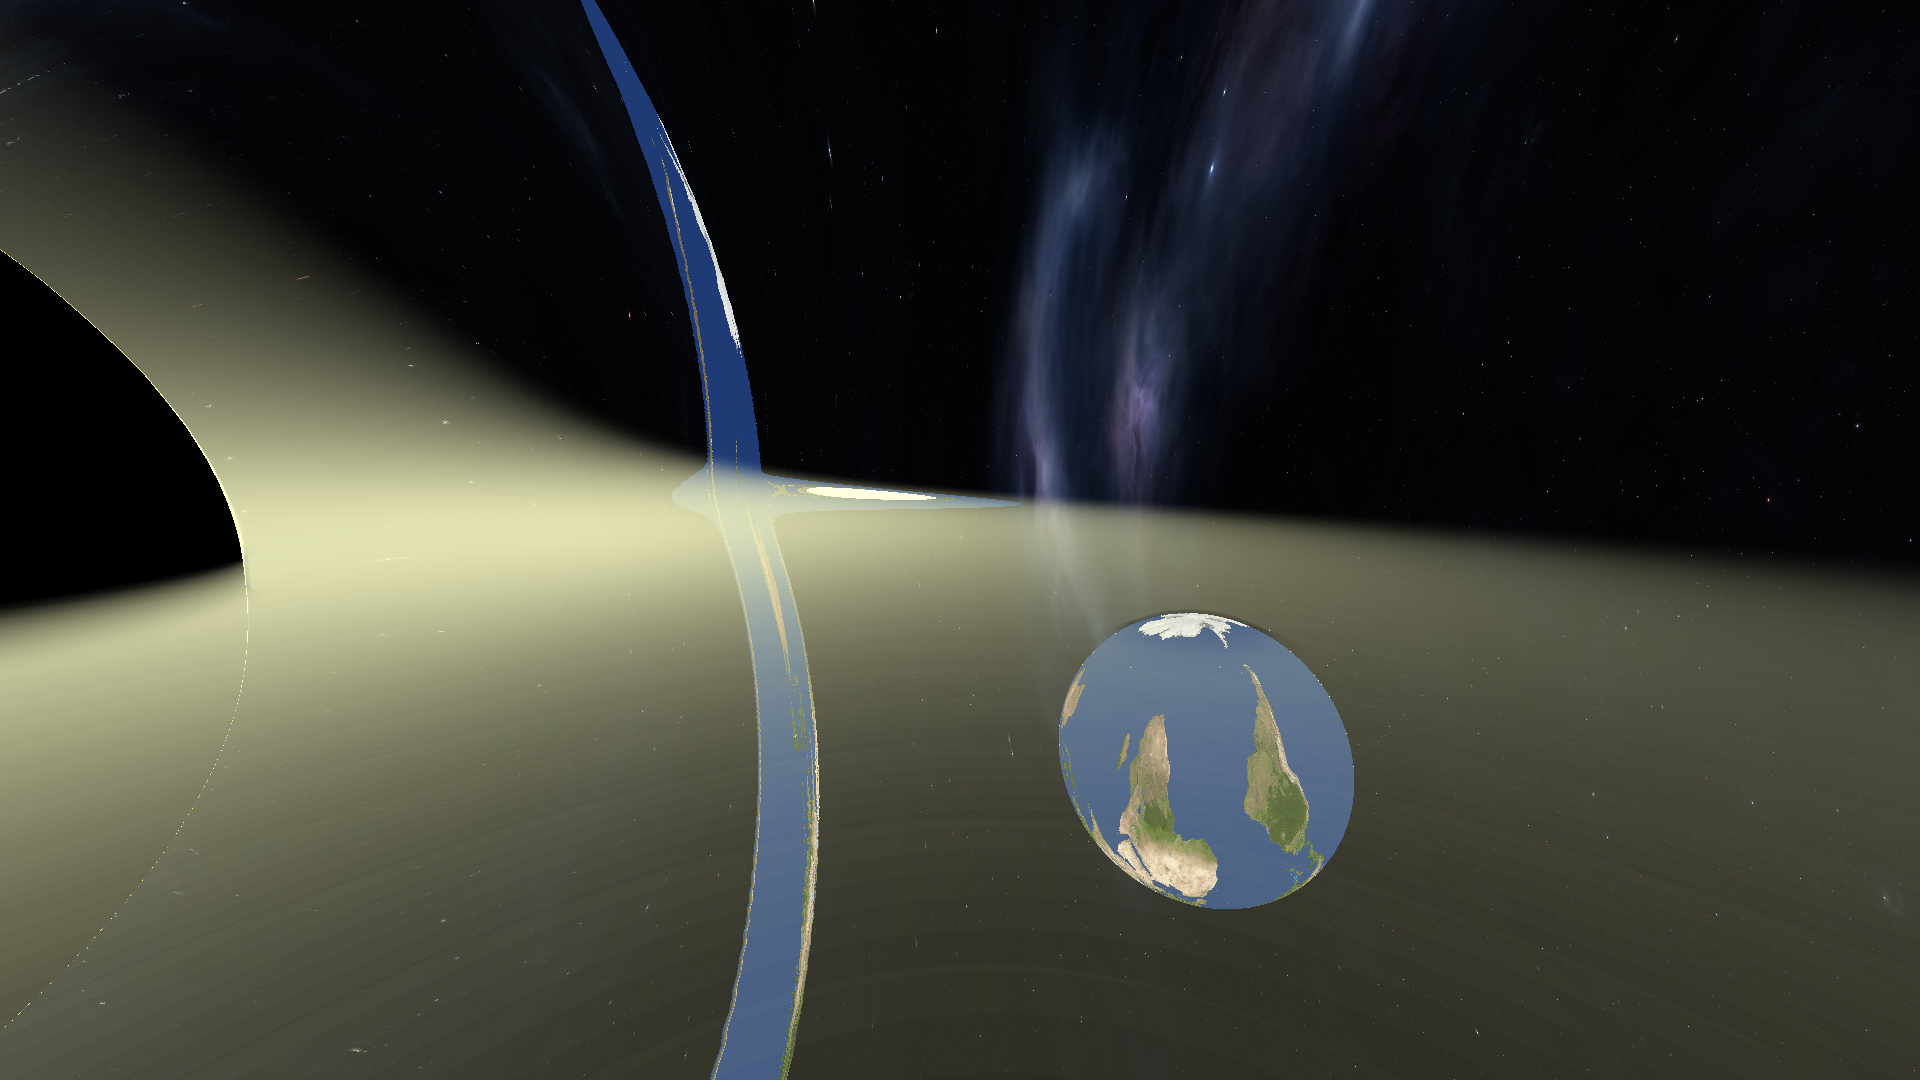

In [ ]:
from PIL import Image

uint8_img = out.astype(np.uint8)
img = Image.fromarray(uint8_img)#.asnumpy(uint8_img))
display(img)